In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
import re
import seaborn as sns  
import csv, sqlite3
import jieba  


matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

## 数据预处理

In [25]:
def re_encode(path):
    with open(path, 'r', encoding='GB2312', errors='ignore') as file:
        lines = file.readlines()
    with open(path, 'w', encoding='utf-8') as file:
        file.write(''.join(lines))
        
re_encode('nCoV_100k_train.labled.csv')

In [26]:
import pandas as pd
train_labled = pd.read_csv('nCoV_100k_train.labled.csv', engine ='python',encoding='utf-8')

train_labled.head(3)

,MicroBlogId,posttime,posteraccount,content,img,video,emo
0,4.460000e+15,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0
1,4.460000e+15,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4.460000e+15,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1


In [27]:

print('Data shapes：', train_labled.shape)
print('Basic characteristics of the data）:',train_labled.columns[:-2])
print('Label data characteristics:',train_labled.columns[-1])
print('All data feature types:\n',train_labled.dtypes)

Data shapes： (100000, 7)
Basic characteristics of the data）: Index(['MicroBlogId', 'posttime', 'posteraccount', 'content', 'img'], dtype='object')
Label data characteristics: emo
All data feature types:
 MicroBlogId      float64
posttime          object
posteraccount     object
content           object
img               object
video             object
emo               object
dtype: object


In [29]:
train_labled['postmonth'] = ''
train_labled['postdate'] = ''
train_labled['postspecifictime'] =''

months = []
dates = []
times = []


for i in train_labled['posttime']:
    a = re.sub(r'月|日',' ',i).split()
    month = int(a[0])
    date = int(a[1])
    time = a[-1]
    months.append(month)
    dates.append(date)
    times.append(time)

train_labled['postmonth'] = months
train_labled['postdate'] = dates
train_labled['postspecifictime'] = times


train_labled = train_labled.drop(['posttime'],axis=1)

train_labled.head(3)

,MicroBlogId,posteraccount,content,img,video,emo,postmonth,postdate,postspecifictime
0,4.460000e+15,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gah...,[],0,1,1,23:50
1,4.460000e+15,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1,1,1,23:58
2,4.460000e+15,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1g...,[],1,1,1,22:39


In [30]:
target = train_labled['emo'].unique()
untargets = []
for i in target:
    if i not in ['-1','0','1']:
        untargets.append(i)
print('Exception label data type:',untargets)


train_labled = train_labled[train_labled['emo'].isin(['-1','0','1'])]

print('Data labels:',train_labled['emo'].unique())

print('The shape of the data after the exception label data is deleted：',train_labled.shape)

Exception label data type: ['-', '4', '-2', nan, '?', '10', '9']
Data labels: ['0' '-1' '1']
The shape of the data after the exception label data is deleted： (99913, 9)


In [31]:
print(train_labled.isnull().sum())

MicroBlogId           0
posteraccount        22
content             353
img                   0
video                 0
emo                   0
postmonth             0
postdate              0
postspecifictime      0
dtype: int64


In [33]:
train_labled['posteraccount'] = train_labled['posteraccount'].fillna(0)

train_labled = train_labled.dropna()

In [34]:

print(train_labled.isnull().sum())

MicroBlogId         0
posteraccount       0
content             0
img                 0
video               0
emo                 0
postmonth           0
postdate            0
postspecifictime    0
dtype: int64


In [35]:
train_labled = train_labled.drop(['img','video'],axis=1)
train_labled.head(3)

,MicroBlogId,posteraccount,content,emo,postmonth,postdate,postspecifictime
0,4.460000e+15,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,1,1,23:50
1,4.460000e+15,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1,1,1,23:58
2,4.460000e+15,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,1,1,1,22:39


In [36]:
print('Data shapes：',train_labled.shape)
print('Data characteristics：\n',train_labled.columns)
print('Data preview')
train_labled.head(5)

Data shapes： (99560, 7)
Data characteristics：
 Index(['MicroBlogId', 'posteraccount', 'content', 'emo', 'postmonth',
       'postdate', 'postspecifictime'],
      dtype='object')
Data preview


,MicroBlogId,posteraccount,content,emo,postmonth,postdate,postspecifictime
0,4.460000e+15,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,1,1,23:50
1,4.460000e+15,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1,1,1,23:58
2,4.460000e+15,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年...,1,1,1,22:39
3,4.460000e+15,芩r,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1,1,1,23:08
4,4.460000e+15,changlwj,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1,1,1,17:42


## 数据分析处理

In [37]:
train_labled['emo'].describe()

count     99560
unique        3
top           0
freq      57287
Name: emo, dtype: object

In [40]:
month = train_labled['postmonth'].unique()
nums = []
for i in month:
    test = train_labled
    
    num = train_labled[train_labled['postmonth']==i]['MicroBlogId'].count()
    nums.append(num)
    
for i in range(month.shape[0]):
    print('{}，The number of Tweet messages about covid-19:{}'.format(month[i], nums[i]))

1，The number of Tweet messages about covid-19:47981
2，The number of Tweet messages about covid-19:51579


In [41]:
train_labled['postmonth'] = train_labled['postmonth'].astype(int)
train_labled['postdate'] = train_labled['postdate'].astype(int)

test1 = train_labled[train_labled['postmonth']==1]
test2 = train_labled[train_labled['postmonth']==2]
nms1 = test1[test1['postdate']>=25]['MicroBlogId'].count()
nms2 = test2[test2['postdate']<=3]['MicroBlogId'].count()
nums = nms1+nms2
print('From January 25 to February 3, the number of relevant Weibo messages totaled:',nums)

From January 25 to February 3, the number of relevant Weibo messages totaled: 26277


## 数据可视化分析

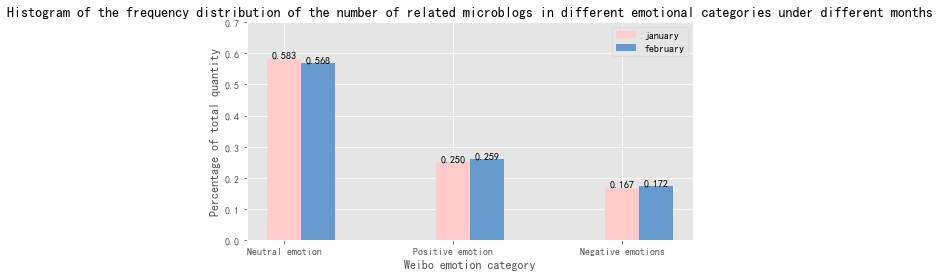

In [43]:
train_labled['emo'] = train_labled['emo'].astype(int)

fig = plt.figure()
fig.set_size_inches(8, 4)


y1 = train_labled[train_labled['postmonth']==1]['emo'].value_counts(normalize=True)
y2 = train_labled[train_labled['postmonth']==2]['emo'].value_counts(normalize=True)
label = ['Neutral emotion','Positive emotion','Negative emotions']
x=np.arange(3)+0.2 

rects1 = plt.bar(label,y1,color='#FFCCCC',width=0.2,label ='january' )  
rects2 = plt.bar(x,y2,color='#6699CC',width=0.2,label ='february') 

for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        

for rect in rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        
plt.ylim(0,0.7)
plt.xlabel('Weibo emotion category',fontsize=12) 
plt.ylabel('Percentage of total quantity',fontsize=12)  
plt.title('Histogram of the frequency distribution of the number of related microblogs in different emotional categories under different months',fontsize=14)  # 标题
plt.style.use('ggplot')  
plt.xticks(size = 10)  
plt.yticks(size = 10) 
plt.legend()
plt.show()

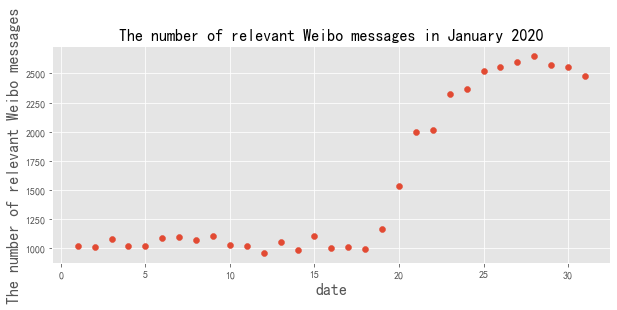

In [44]:
date = train_labled['postdate'].unique()

nums1 = []
for i in date:
    test = train_labled[train_labled['postmonth']==1]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums1.append(num)


x = date 
y1 = nums1


fig = plt.figure()
fig.set_size_inches(10, 4)

plt.scatter(x,y1)

plt.style.use('ggplot') 
plt.title('The number of relevant Weibo messages in January 2020',fontsize=16)
plt.xlabel('date', fontsize=16)
plt.ylabel('The number of relevant Weibo messages', fontsize=16)


plt.show()  

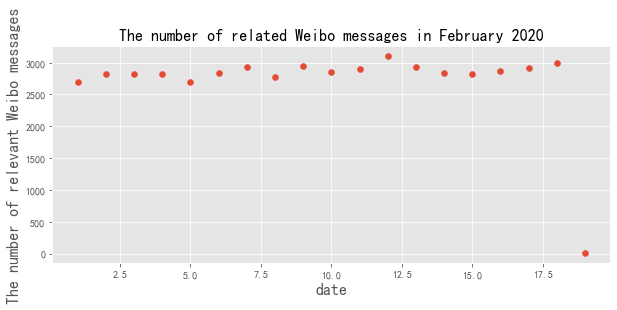

In [46]:

date = train_labled[train_labled['postmonth']==2]['postdate'].unique()

nums1 = [] 
for i in date:
    test = train_labled[train_labled['postmonth']==2]
    num = test[test['postdate']==i]['postdate'].count()
    nums1.append(num)


x = date 
y1 = nums1



fig = plt.figure()
fig.set_size_inches(10, 4)

plt.scatter(x,y1)

plt.style.use('ggplot') 
plt.title('The number of related Weibo messages in February 2020',fontsize=16) 
plt.xlabel('date', fontsize=16)
plt.ylabel('The number of relevant Weibo messages', fontsize=16)


plt.show()  

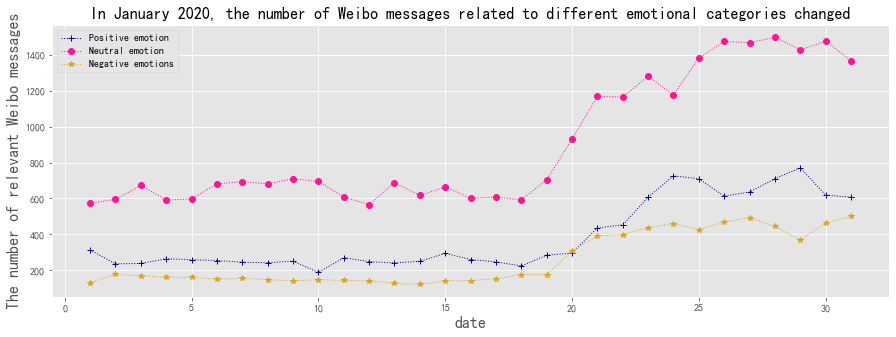

In [49]:

date = train_labled['postdate'].unique()


for i in date:
    test = train_labled[train_labled['postmonth']==1]
    test = test[test['emo']==1]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums1.append(num)
    
nums2 = []  
for i in date:
    test = train_labled[train_labled['postmonth']==1]
    test = test[test['emo']==0]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums2.append(num)
    
nums3 = [] 
for i in date:
    test = train_labled[train_labled['postmonth']==1]
    test = test[test['emo']==-1]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums3.append(num)
    
x_index = date.argsort() 


x = date[x_index]
y1 = np.array(nums1)[x_index]
y2 = np.array(nums2)[x_index]
y3 = np.array(nums3)[x_index]


fig = plt.figure()
fig.set_size_inches(15, 5)


plt.plot(x,y1,label='Positive emotion',color="darkblue",linestyle=':',linewidth=1, marker='+')
plt.plot(x,y2,label='Neutral emotion',color="deeppink",linestyle=':',linewidth=1, marker='o')
plt.plot(x,y3,label='Negative emotions',color="goldenrod",linestyle=':',linewidth=1, marker='*')

plt.style.use('ggplot')
plt.title('In January 2020, the number of Weibo messages related to different emotional categories changed',fontsize=16)  # 标题
plt.xlabel('date', fontsize=16)
plt.ylabel('The number of relevant Weibo messages', fontsize=16)

plt.legend()  
plt.show()  

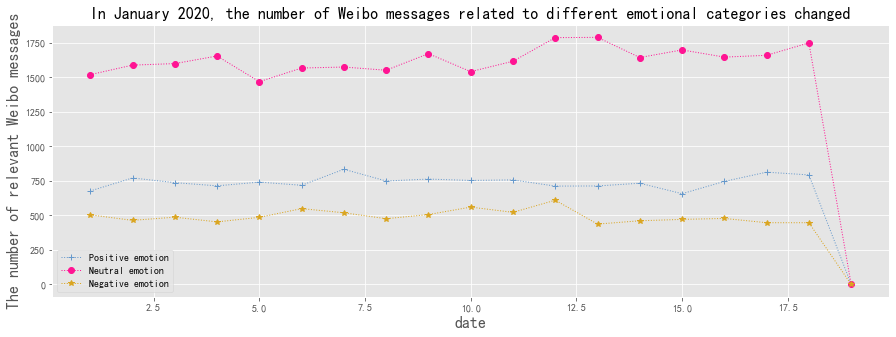

In [51]:


date = train_labled[train_labled['postmonth']==2]['postdate'].unique()

nums1 = []  
for i in date:
    test = train_labled[train_labled['postmonth']==2]
    test = test[test['emo']==1]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums1.append(num)
    
nums2 = []  
for i in date:
    test = train_labled[train_labled['postmonth']==2]
    test = test[test['emo']==0]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums2.append(num)
    
nums3 = [] 
for i in date:
    test = train_labled[train_labled['postmonth']==2]
    test = test[test['emo']==-1]
    num = test[test['postdate']==i]['MicroBlogId'].count()
    nums3.append(num)
    
x_index = date.argsort() 


x = date[x_index]
y1 = np.array(nums1)[x_index]
y2 = np.array(nums2)[x_index]
y3 = np.array(nums3)[x_index]



fig = plt.figure()
fig.set_size_inches(15, 5)

plt.plot(x,y1,label='Positive emotion',color="#6699CC",linestyle=':',linewidth=1, marker='+')
plt.plot(x,y2,label='Neutral emotion',color="deeppink",linestyle=':',linewidth=1, marker='o')
plt.plot(x,y3,label='Negative emotion',color="goldenrod",linestyle=':',linewidth=1, marker='*')

plt.style.use('ggplot')
plt.title('In January 2020, the number of Weibo messages related to different emotional categories changed',fontsize=16)  # 标题
plt.xlabel('date', fontsize=16)
plt.ylabel('The number of relevant Weibo messages', fontsize=16)

plt.legend() 
plt.show()  

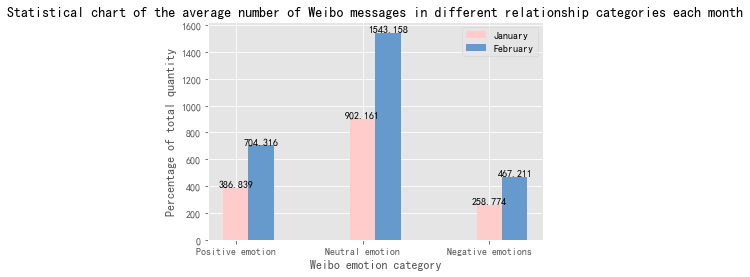

In [52]:
test1 = train_labled[train_labled['postmonth']==1]
test2 = train_labled[train_labled['postmonth']==2]


num1_mean = []
num2_mean = []

date1 = test1['postdate'].unique()
date2 = test2['postdate'].unique()



num1_mean.append(test1[test1['emo']==1]['MicroBlogId'].count()/len(date1))
num1_mean.append(test1[test1['emo']==0]['MicroBlogId'].count()/len(date1))
num1_mean.append(test1[test1['emo']==-1]['MicroBlogId'].count()/len(date1))

num2_mean.append(test2[test2['emo']==1]['MicroBlogId'].count()/len(date2))
num2_mean.append(test2[test2['emo']==0]['MicroBlogId'].count()/len(date2))
num2_mean.append(test2[test2['emo']==-1]['MicroBlogId'].count()/len(date2))


y1 = num1_mean
y2 = num2_mean
label = ['Positive emotion','Neutral emotion','Negative emotions']
x=np.arange(3)+0.2 

rects1 = plt.bar(label,y1,color='#FFCCCC',width=0.2,label ='January' )  
rects2 = plt.bar(x,y2,color='#6699CC',width=0.2,label ='February') 


for rect in rects1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        

for rect in rects2:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height, format(height,'.3f'), ha="center", va="bottom",fontsize=10)
        

plt.xlabel('Weibo emotion category',fontsize=12)  
plt.ylabel('Percentage of total quantity',fontsize=12)  
plt.title('Statistical chart of the average number of Weibo messages in different relationship categories each month',fontsize=14)  # 标题
plt.style.use('ggplot')  
plt.xticks(size = 10)  
plt.yticks(size = 10)  
plt.legend()
plt.show()


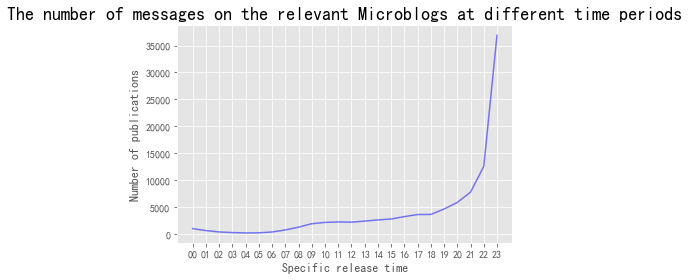

In [53]:

test1 = train_labled['postspecifictime'].values.tolist()

times= []
for i in range(len(test1)):
    time = test1[i].split(':')[0]
    times.append(time)

test2 = train_labled['emo'].values.tolist()

test3 = pd.DataFrame({'postspecifictime':times})

x_index = test3['postspecifictime'].unique().argsort()
x = test3['postspecifictime'].unique()[test3['postspecifictime'].unique().argsort()]

nums = []
for i in x:
    num = test3[test3['postspecifictime']==i]['postspecifictime'].count()
    nums.append(num)
y = nums


fig = plt.figure()
fig.set_size_inches(6, 4)


plt.plot(x,y,color='blue',alpha=0.5)
        
plt.xlabel('Specific release time',fontsize=12) 
plt.ylabel('Number of publications',fontsize=12)  
plt.title('The number of messages on the relevant Microblogs at different time periods',fontsize=18)
plt.style.use('ggplot') 
plt.xticks(size = 10)  
plt.yticks(size = 10) 
plt.show()

In [54]:
print(train_labled.dtypes)


train_labled["emo"] = pd.to_numeric(train_labled["emo"],errors='coerce')


MicroBlogId         float64
posteraccount        object
content              object
emo                   int32
postmonth             int32
postdate              int32
postspecifictime     object
dtype: object


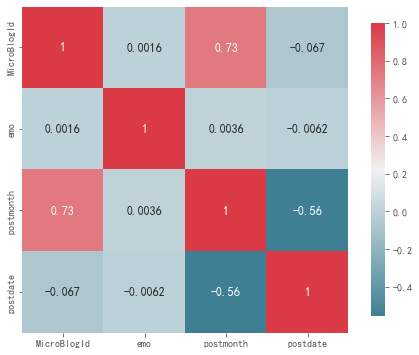

In [55]:
_, ax = plt.subplots(figsize=(8, 6))  
corr = train_labled.corr(method='pearson') 
# corr = df.corr(method='kendall')
# corr = df.corr(method='spearman')
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
_ = sns.heatmap(
    corr,  
    cmap=cmap,  
    square=True, 
    cbar_kws={'shrink': .9},  
    ax=ax,  
    annot=True,  
    annot_kws={'fontsize': 12}) 

plt.show()